# Your first deep neural network

# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Flatten, Dense, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.datasets import cifar10

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

2022-12-26 20:34:02.933052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
torch.__version__

'1.13.0'

# data

In [3]:
NUM_CLASSES = 10

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train_index = np.array(y_train)
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [6]:
x_train[54, 12, 13, 1] 

0.36862746

# architecture

In [7]:
input_layer = Input((32,32,3))

x = Flatten()(input_layer)

x = Dense(200, activation = 'relu')(x)
x = Dense(150, activation = 'relu')(x)

output_layer = Dense(NUM_CLASSES, activation = 'softmax')(x)

model = Model(input_layer, output_layer)

2022-12-26 20:34:17.050687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 200)               614600    
                                                                 
 dense_1 (Dense)             (None, 150)               30150     
                                                                 
 dense_2 (Dense)             (None, 10)                1510      
                                                                 
Total params: 646,260
Trainable params: 646,260
Non-trainable params: 0
_________________________________________________________________


### Pytorch Model Replica

In [9]:
class PytorchModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(3072, 200)
        self.dense2 = nn.Linear(200, 150)
        self.dense3 = nn.Linear(150, 10)
        self._initialize_weights()
        
    def forward(self, x):
        out = self.flatten(x)
        out = self.dense1(out)
        out = nn.functional.relu(out)
        out = self.dense2(out)
        out = nn.functional.relu(out)
        out = self.dense3(out)
        out = nn.functional.softmax(out, dim=1)
        return out
    
    def _initialize_weights(self):
        with torch.no_grad():
            self.apply(self.init_weights)
                
    @staticmethod
    def init_weights(layer):
        if hasattr(layer, "weight"):
            torch.nn.init.xavier_uniform_(layer.weight)
            
        if hasattr(layer, "bias"):
            layer.bias.data.fill_(0.0)
            
    def fit(self, X, y, learning_rate=0.0005, batch_size=32, epochs=10, shuffle=True):
        optimizer = torch.optim.Adam(lr=learning_rate, params=self.parameters())
        dataset = TensorDataset(X, y)
        train_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
        )

        loss_fn = nn.NLLLoss(reduction="sum")
        for epoch in range(1, epochs + 1):
            n, total_loss = 0, 0.0
            for obs, labels in train_loader:
                outputs = self(obs)
                loss = loss_fn(torch.log(outputs), labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                n += outputs.shape[0]
                total_loss += float(loss.item())
                
            avg_loss = 1.0 * total_loss / n
            print(f"Epoch {epoch} Loss: {avg_loss:.6f}")
        
        return self

In [10]:
pytorch_model = PytorchModel()
pytorch_model.fit(
    torch.from_numpy(x_train).type(torch.float32), 
    torch.from_numpy(y_train_index).squeeze(-1).type(torch.LongTensor),
)

Epoch 1 Loss: 1.850617
Epoch 2 Loss: 1.661120
Epoch 3 Loss: 1.586059
Epoch 4 Loss: 1.529043
Epoch 5 Loss: 1.492188
Epoch 6 Loss: 1.458285
Epoch 7 Loss: 1.432439
Epoch 8 Loss: 1.407447
Epoch 9 Loss: 1.383896
Epoch 10 Loss: 1.365427


PytorchModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=3072, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=150, bias=True)
  (dense3): Linear(in_features=150, out_features=10, bias=True)
)

In [11]:
pytorch_model(torch.from_numpy(x_train))[:10]

tensor([[2.0020e-02, 5.3272e-03, 7.8797e-02, 1.4464e-01, 1.5983e-01, 1.3996e-01,
         4.0391e-01, 4.6075e-02, 6.3768e-04, 7.9979e-04],
        [1.9629e-02, 3.5448e-01, 6.4850e-03, 3.5640e-02, 1.1561e-02, 6.5159e-02,
         6.7135e-03, 1.0378e-01, 2.2666e-01, 1.6989e-01],
        [3.9498e-02, 3.0112e-02, 1.8129e-03, 6.9305e-03, 1.2270e-03, 1.3269e-03,
         5.8668e-04, 4.5070e-03, 6.7759e-02, 8.4624e-01],
        [1.6030e-02, 2.0547e-02, 8.6281e-02, 6.1157e-02, 3.1410e-01, 7.0678e-02,
         4.1426e-01, 5.8125e-03, 5.2612e-03, 5.8743e-03],
        [4.9502e-01, 1.9223e-01, 5.1670e-04, 6.5605e-04, 1.8620e-03, 7.2936e-04,
         1.8857e-05, 1.5826e-03, 2.7347e-01, 3.3916e-02],
        [2.6563e-02, 3.1941e-01, 6.0873e-03, 2.0592e-02, 2.0340e-02, 6.6780e-02,
         2.4298e-02, 1.3107e-01, 3.3360e-03, 3.8153e-01],
        [1.3815e-01, 8.6355e-03, 3.3558e-01, 2.3884e-02, 1.5914e-01, 4.6574e-02,
         2.7138e-01, 1.0383e-02, 2.8806e-03, 3.3923e-03],
        [1.1952e-04, 2.7230

# train

In [12]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/Users/benjamincross/miniconda3/envs/GDL/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
model.fit(x_train
          , y_train
          , batch_size=32
          , epochs=10
          , shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 9s 5ms/step - loss: 1.8473 - accuracy: 0.3339
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6639 - accuracy: 0.4061
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5847 - accuracy: 0.4348
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5330 - accuracy: 0.4536
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4981 - accuracy: 0.4676
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4651 - accuracy: 0.4776
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4354 - accuracy: 0.4895
Epoch 8/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4153 - accuracy: 0.4954
Epoch 9/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3909 - accuracy: 0.5055
Epoch 10/10
1563/1563 [==============================] - 9s 5ms/step - loss: 1.366

# analysis

In [14]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.4309 - accuracy: 0.4891


[1.4309080839157104, 0.48910000920295715]

In [15]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

313/313 [==============================] - 1s 2ms/step


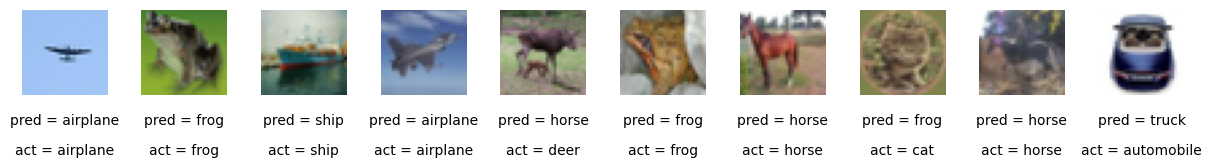

In [16]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)

### Pytorch Analysis

In [17]:
preds = pytorch_model(torch.from_numpy(x_test))
pred_classes = CLASSES[torch.argmax(preds, axis=-1)]

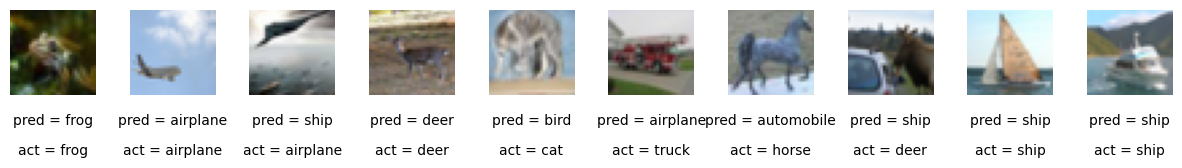

In [18]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(pred_classes[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)

In [19]:
print("Accuracy: {:.4f}".format((pred_classes == actual_single).mean()))

Accuracy: 0.4901
